## Using Tensorflow

In [1]:
import numpy as np
# import data
from keras.datasets import mnist
import tensorflow as tf

mnist_data = mnist.load_data()

In [2]:
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

np.random.seed(0)
train_indices = np.random.choice(60000, 50000, replace=False)
valid_indices = [i for i in range(60000) if i not in train_indices]

X_valid, y_valid = X_train[valid_indices,:,:], y_train[valid_indices]
X_train, y_train = X_train[train_indices,:,:], y_train[train_indices]
print(X_train.shape, X_valid.shape, X_test.shape)
# (50000, 28, 28) (10000, 28, 28) (10000, 28, 28)

image_size = 28
num_labels = 10

def reformat(dataset, labels):
 dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
 # one hot encoding: Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...] 
 labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
 return dataset, labels

X_train, y_train = reformat(X_train, y_train)
X_valid, y_valid = reformat(X_valid, y_valid)
X_test, y_test = reformat(X_test, y_test)
print('Training set', X_train.shape, y_train.shape)
print('Validation set', X_valid.shape, y_valid.shape)
print('Test set', X_test.shape, y_test.shape)
# Training set (50000, 784) (50000, 10) # Validation set (10000, 784) (10000, 10) # Test set (10000, 784) (10000, 10)

(50000, 28, 28) (10000, 28, 28) (10000, 28, 28)
Training set (50000, 784) (50000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [3]:
import tensorflow as tf
import numpy as np

def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

batch_size = 256 
num_hidden_units = 1024
lambda1 = 0.1 
lambda2 = 0.1 

graph = tf.Graph()

with graph.as_default():
    # Input data placeholders
    tf_train_dataset = tf.compat.v1.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.compat.v1.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(X_valid) 
    tf_test_dataset = tf.constant(X_test) 
    
    # Variables
    weights1 = tf.Variable(tf.random.truncated_normal([image_size * image_size, num_hidden_units]))
    biases1 = tf.Variable(tf.zeros([num_hidden_units]))
    weights2 = tf.Variable(tf.random.truncated_normal([num_hidden_units, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels])) 

    # Hidden layer computation with ReLU activation
    hidden_layer_output = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)

    
    # Logits computation
    logits = tf.matmul(hidden_layer_output, weights2) + biases2
    
    # Softmax activation for logits
    softmax_logits = tf.nn.softmax(logits)

    # Loss computation
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=softmax_logits) + \
                          lambda1 * tf.nn.l2_loss(weights1) + lambda2 * tf.nn.l2_loss(weights2)) 
    
    # Optimizer
    optimizer = tf.compat.v1.train.GradientDescentOptimizer(0.008).minimize(loss)
    
    # Predictions for the training, validation, and test data.
    train_prediction = softmax_logits
    valid_hidden_layer_output = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_prediction = tf.nn.softmax(tf.matmul(valid_hidden_layer_output, weights2) + biases2)
    test_hidden_layer_output = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_prediction = tf.nn.softmax(tf.matmul(test_hidden_layer_output, weights2) + biases2)

In [4]:
with tf.compat.v1.Session(graph=graph) as session:
    session.run(tf.compat.v1.global_variables_initializer())
    
    num_steps = 6001
    ll = []
    atr = []
    av = []

    for step in range(num_steps):
        off = (step * batch_size) % (y_train.shape[0] - batch_size)
        batch_data = X_train[off:(off + batch_size), :]
        batch_labels = y_train[off:(off + batch_size), :]

        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    
        
        if (step % 500 == 0):
            ll.append(l)
            a = accuracy(predictions, batch_labels)
            atr.append(a)
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % a)
            a = accuracy(valid_prediction.eval(), y_valid)
            av.append(a)
            print("Validation accuracy: %.1f%%" % a) 
            print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), y_test))

2023-08-28 10:37:29.490224: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled


Minibatch loss at step 0: 31508.888672
Minibatch accuracy: 5.1%
Validation accuracy: 6.8%
Test accuracy: 6.4%
Minibatch loss at step 500: 14154.652344
Minibatch accuracy: 9.8%
Validation accuracy: 10.1%
Test accuracy: 9.7%
Minibatch loss at step 1000: 6359.363281
Minibatch accuracy: 12.1%
Validation accuracy: 15.3%
Test accuracy: 15.1%
Minibatch loss at step 1500: 2857.713623
Minibatch accuracy: 24.6%
Validation accuracy: 23.1%
Test accuracy: 22.8%
Minibatch loss at step 2000: 1284.833984
Minibatch accuracy: 30.1%
Validation accuracy: 34.9%
Test accuracy: 34.0%
Minibatch loss at step 2500: 578.225098
Minibatch accuracy: 41.0%
Validation accuracy: 42.4%
Test accuracy: 42.0%
Minibatch loss at step 3000: 260.748566
Minibatch accuracy: 53.9%
Validation accuracy: 54.1%
Test accuracy: 54.8%
Minibatch loss at step 3500: 118.143661
Minibatch accuracy: 59.4%
Validation accuracy: 60.6%
Test accuracy: 60.8%
Minibatch loss at step 4000: 54.097023
Minibatch accuracy: 60.5%
Validation accuracy: 62.8

In [5]:
final_length = len(av)
indices = [i for i in range(1, final_length + 1)]

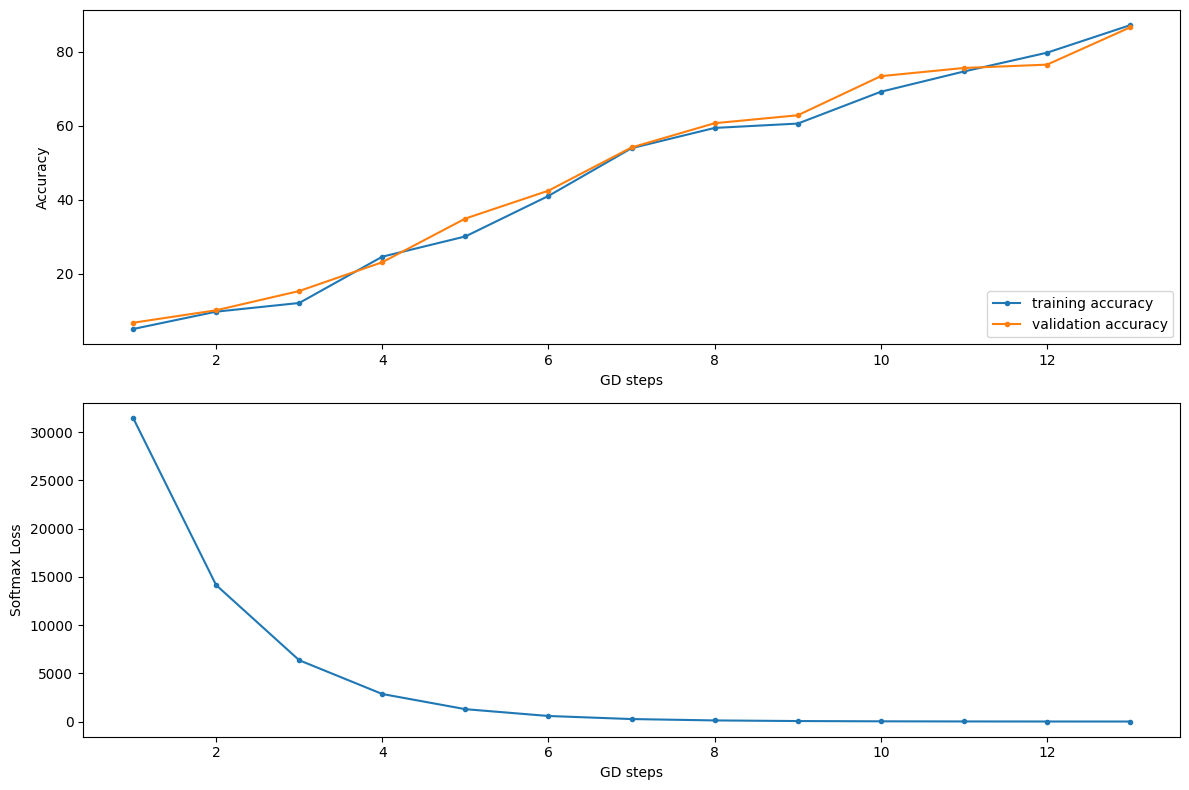

In [6]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(12, 8))

plt.subplot(211)
plt.plot(indices, atr, '.-', label='training accuracy')
plt.plot(indices, av, '.-', label='validation accuracy')
plt.xlabel('GD steps')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(212)
plt.plot(indices, ll, '.-')
plt.xlabel('GD steps')
plt.ylabel('Softmax Loss')

plt.tight_layout()
plt.show()

## Using Keras (CNN + dropout and momentum)

(60000, 28, 28) (10000, 28, 28)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)          

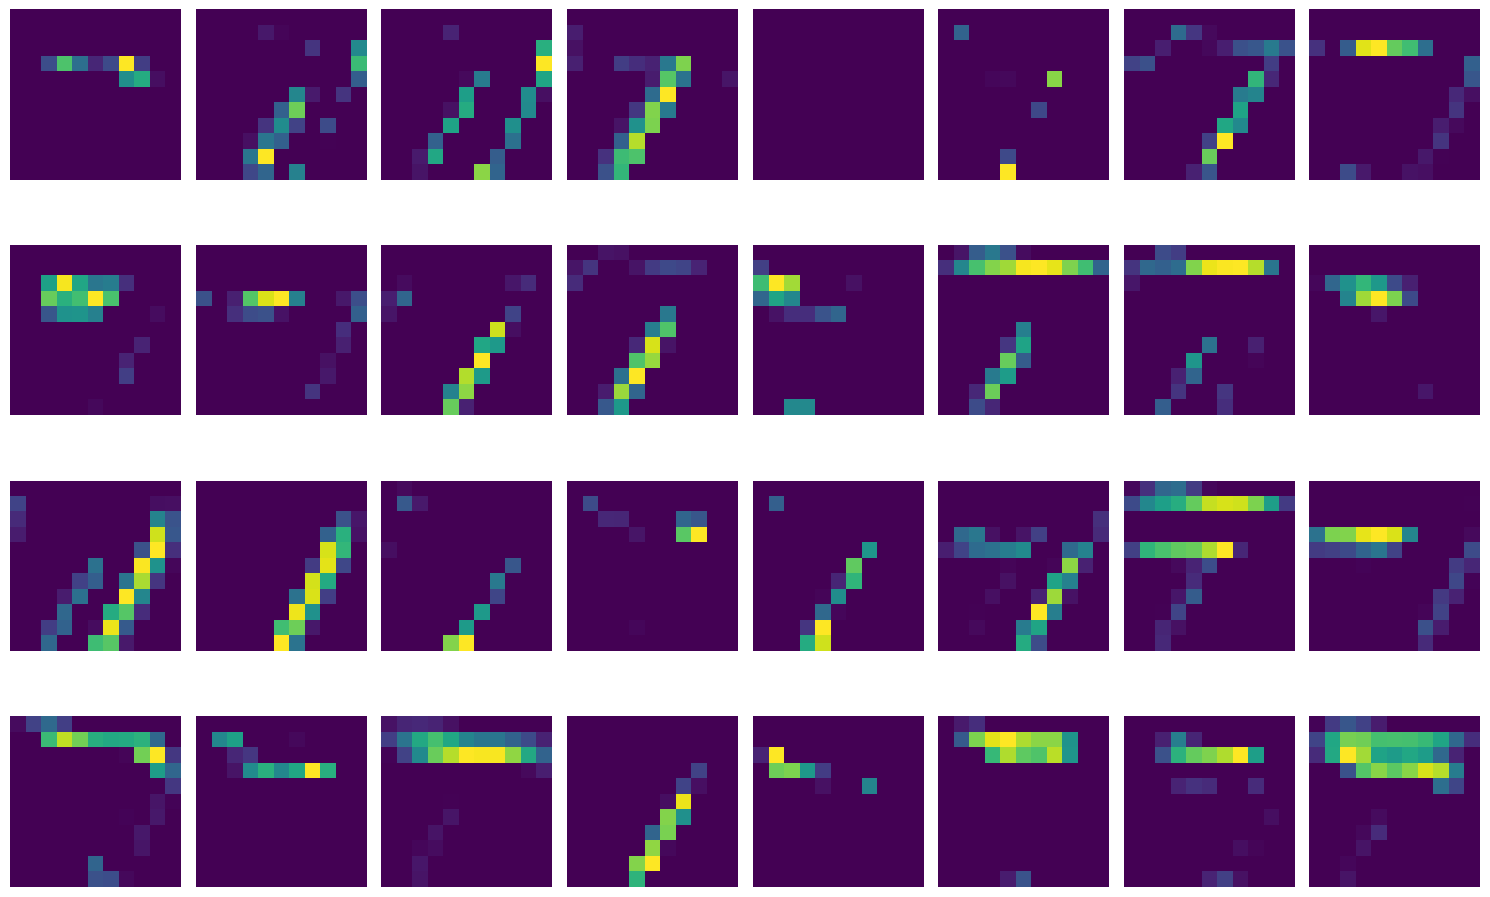

Accuracy: 0.9908999800682068 
 Error: 0.9100019931793213


In [7]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from keras.utils import to_categorical

# import data
from keras.datasets import mnist
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape, X_test.shape)
# (60000, 28, 28) (10000, 28, 28)
# reshape to be [samples][pixels][width][height]
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')
X_train = X_train / 255 # normalize training data
X_test = X_test / 255 # normalize test data
y_train = to_categorical(y_train) # to one-hot-encoding of the labels
y_test = to_categorical(y_test)
num_classes = y_test.shape[1] # number of categories

def CNN_model(): 
    # create model
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# build the model
model = CNN_model()
model.summary()
# fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)

# Create a model for intermediate layer visualization
intermediate_layer_model = Model(inputs=model.input, outputs=model.layers[2].output)
intermediate_output = intermediate_layer_model.predict(X_test)

# Visualize the activations of the intermediate layer
plt.figure(figsize=(15, 10))
plt.subplots_adjust(left=0.03, right=0.97, bottom=0.03, top=0.97, hspace=0.3, wspace=0.2)
for i in range(32):  # Visualize 32 filters
    ax = plt.subplot(4, 8, i + 1)
    plt.imshow(intermediate_output[0, :, :, i], cmap='viridis')  # Choose a test sample (index 0) and one filter (index i)
    plt.axis('off')

plt.tight_layout()
plt.show()

# evaluate the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: {} \n Error: {}".format(scores[1], 100-scores[1]*100))